### Similarity Score

When doing similarity search using vector databases, we search for k closest vectors. But how does that work internally?

Answer is that each question is converted to a corresponding embedding and then a distance strategy is used to find distance between the vectors. For FAISS, the distance strategy is set to DistanceStrategy.EUCLIDEAN_DISTANCE by default.

Now, if we want similarity score to be between -1 to 1, we must use cosine similarity for search similarity score. Here I will demonstrate how to use cosine similarity and compare vectors for their similarity score.

Here 1 means vectors are same and -1 means vectors are opposite

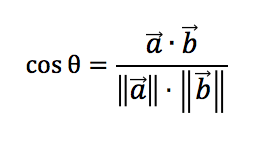

The above is formula for cosine similarity where `a` and `b` are 2 vectors(embeddings of a string)

We will take user query and make vector embeddings as vector `a` and then for all docs in vectorDB, run this formula for vectors of each chunk/document. Then we sort it based on highest similarity

In [1]:
%pip install -q langchain langchain-community langchain-text-splitters scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Chunk the pdf into chunks and convert them to documents

- load the pdf using langchain PyPDFLoader
- chunk into sizes of 250 with 20 overlap for context via RecursiveCharacterTextSplitter

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

file_path = "../data/who_stats_2022.pdf"

loader = PyPDFLoader(file_path=file_path)
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=250,
    chunk_overlap=20,
)

pdf_pages = loader.load_and_split(text_splitter=text_splitter)


In [3]:
len(pdf_pages)

2405

In [4]:
vars(pdf_pages[100])

{'id': None,
 'metadata': {'source': '../data/who_stats_2022.pdf', 'page': 8},
 'page_content': '33% in 2000. The number of adults aged 30–79 years with raised blood pressure (hypertension) is estimated \nto have almost doubled to 1.28 billion between 1990 and 2019, mainly due to population growth and ageing.',
 'type': 'Document'}

#### We want similarity score of chunks with this query

For this we have to create embeddings for each page_content as well

In [5]:
query = "What was effect of covid 19 in middle east?"

In [6]:
chunk_texts = [p.page_content for p in pdf_pages] # get only texts as we focus on similarity score

#### Create embeddings using Hugging face functions

In [7]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

# use the open-source embedding function to convert text to embeddings, can choose another function as per leaderboard - https://huggingface.co/spaces/mteb/leaderboard
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\VARUN ARORA\AppData\Local\Temp\ipykernel_11180\1287374911.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
d:\VS Code\python\GenAI-Cookbook\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
d:\VS Code\python\GenAI-Cookbook\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by defa

In [8]:
chunk_embeddings = embedding_function.embed_documents(chunk_texts) # gives list of embeddings(which are list of float numbers)

In [9]:
# print(chunk_embeddings[0])
len(chunk_embeddings[0]) # linear vector of length 384 is generated as embedding for 0th chunk text

384

### Embed user query

In [10]:
query_embedding = embedding_function.embed_query(query)

In [11]:
%pip install -q numpy

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np

query_embedding = np.array(query_embedding).reshape(1,-1) # for cosine similarity

In [13]:
query_embedding.shape

(1, 384)

In [14]:
chunk_embeddings = [np.array(ce).reshape(1,-1) for ce in chunk_embeddings] # reshape for cosine similarity

#### Create cosine similarity and give top 10 similar vectors

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(query_embedding, chunk_embeddings[0])

array([[0.21760679]])

The above is similarity score in range [0,1] for query and chunk embedding based off cosine similarity

#### Doing cosine similarity for all chunks

In [16]:
similarities = [cosine_similarity(query_embedding, ce) for ce in chunk_embeddings]

In [17]:
similarities[1]

array([[0.21760679]])

In [18]:
similarities[1][0][0]

0.2176067916557493

In [19]:
similarities[1].shape

(1, 1)

### Sort based off similarities

In [20]:
chunk_score_list = [(chunk_texts[i], similarities[i][0][0]) for i in range(len(similarities))]

In [21]:
chunk_score_list[:3]

[('World \nHealth \nStatistics \n2022\nMonitoring  \nhealth for the  \nSDG s\nSustainable Development Goals',
  0.2176067916557493),
 ('World \nHealth \nStatistics \n2022\nMonitoring  \nhealth for the  \nSDG s\nSustainable Development Goals',
  0.2176067916557493),
 ('World health statistics 2022: monitoring health for the SDGs, sustainable development goals\nISBN 978-92-4-005114-0 (electronic version)\nISBN 978-92-4-005115-7 (print version)\n© World Health Organization 2022',
  0.23928306724151702)]

In [22]:
sorted_chunk_score_list = sorted(chunk_score_list, key=lambda x: x[1], reverse=True) # sort based on similarity(2nd ele of tuple) in descending order

#### Getting the top 10 most similar chunks

In [23]:
sorted_chunk_score_list[:10]

[('true impact of the COVID-19 pandemic. Iraq and Tunisia also reported \non monthly total deaths and were able to determine excess deaths \nin 2020 in comparison to 2019. \nSeven countries in the Eastern Mediterranean Region have reported',
  0.6641347167072867),
 ('15. Roberton T, Carter ED, Chou VB, Stegmuller AR, Jackson BD, Tam Y, et al. Early estimates of the indirect effects of the COVID-19',
  0.6533679664352592),
 ('• Progression and impact of the COVID-19 pandemic  ..................................................................................................................... 1',
  0.6422023115978144),
 ('Progression \nand impact of \nthe COVID-19 \npandemic01',
  0.6185028984897357),
 ('Classification of Diseases (10th revision) was key to enable countries \nto identify the impact of COVID-19 to cause deaths within their top \n10 leading causes of death. Mortality data for Lebanon, Oman, Qatar,',
  0.6157655627126775),
 ('and middle-income countries and compared them wi

#### Getting last 10 least similar chunks

In [24]:
sorted_chunk_score_list[-10:]

[('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesCompar

Cosine similarity gives in range [-1,1] where 1 means same and -1 means vector is opposite

By this way, you can find most similar texts and do RAG on it as in similarity_score_rag.ipynb